In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.metrics import recall_score, accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from collections import Counter

In [2]:
df=pd.read_csv("Breast_Cancer.csv")
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


# Data Extraction and Cleaning

In [3]:
df.rename({'Tumor Size':'Tumor Size (mm)','T Stage ':'T Stage','Reginol Node Positive':'Regional Node Positive','differentiate':'Differentiate'}, axis=1, inplace=True)
df['Grade']=df['Grade'].map({'1':'Grade 1','2':'Grade 2','3':'Grade 3',' anaplastic; Grade IV':'Grade 4'})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   Differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size (mm)         4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Regional Node Positive  4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [5]:
df.isnull().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
Differentiate             0
Grade                     0
A Stage                   0
Tumor Size (mm)           0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Regional Node Positive    0
Survival Months           0
Status                    0
dtype: int64

# Dealing with Outliers

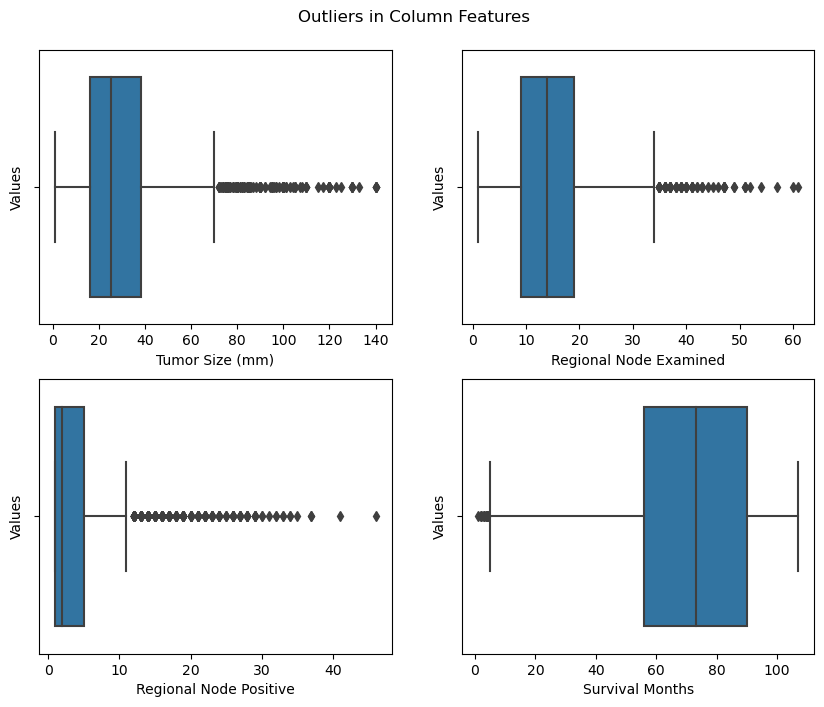

In [15]:
num_cols = ['Tumor Size (mm)', 'Regional Node Examined', 'Regional Node Positive', 'Survival Months']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8), dpi=100)
fig.suptitle('Outliers in Column Features', y = 0.93);
for col, ax in zip(num_cols, axes.ravel()):
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_ylabel('Values')

In [4]:
outlier_cols=['Tumor Size (mm)', 'Regional Node Examined', 'Regional Node Positive']
outlier_index=[]
outlier_ind_list=[]
for col in outlier_cols:    
    Q1=np.percentile(df[col],25,interpolation='midpoint')
    Q3=np.percentile(df[col],75,interpolation='midpoint')    
    IQR=Q3-Q1    
    upper_bound=Q3+(1.5*IQR)
    lower_bound=Q1-(1.5*IQR)    
    upper_outliers=df[col] >= upper_bound
    lower_outliers=df[col] <= lower_bound
    outliers=df[upper_outliers | lower_outliers].index
    outlier_index.extend(outliers)
    
outlier_index = Counter(outlier_index)
for key in outlier_index.keys():
    outlier_ind_list.append(key)
df = df.drop(outlier_ind_list)
print(f'Number of outliers: {len(outlier_ind_list)}')

Number of outliers: 617


# EDA

In [17]:
df.describe()

,Age,Tumor Size (mm),Regional Node Examined,Regional Node Positive,Survival Months
count,3407.000000,3407.000000,3407.000000,3407.000000,3407.000000
mean,53.984444,26.142941,13.092457,2.665982,72.314940
std,8.912773,14.668958,7.036268,2.214953,22.173282
min,30.000000,1.000000,1.000000,1.000000,2.000000
25%,47.000000,15.000000,8.000000,1.000000,57.000000
50%,54.000000,22.000000,13.000000,2.000000,74.000000
75%,61.000000,33.000000,18.000000,3.000000,90.000000
max,69.000000,70.000000,33.000000,10.000000,107.000000


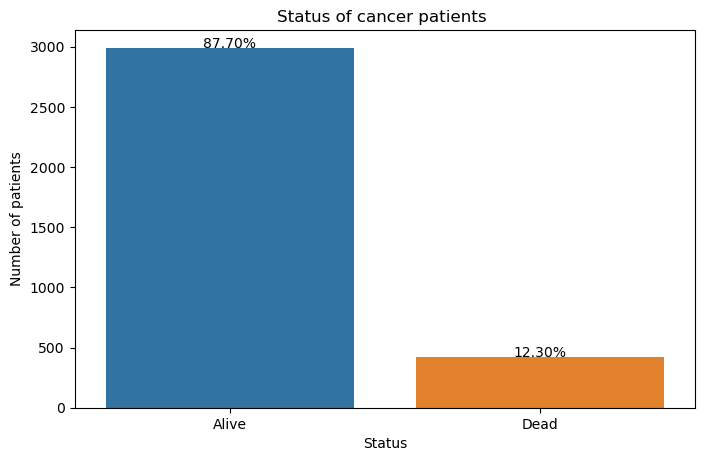

In [28]:
fig,ax=plt.subplots(figsize=(8,5),dpi=100)
sns.countplot(data=df,x='Status')
ax.set_xlabel("Status")
ax.set_ylabel("Number of patients")
ax.set_title("Status of cancer patients ")
percentage=round(df['Status'].value_counts()*100/len(df),2)
patches=ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()
   ax.annotate('{:.2f}%'.format(percentage[i]),(x,y),ha='center')

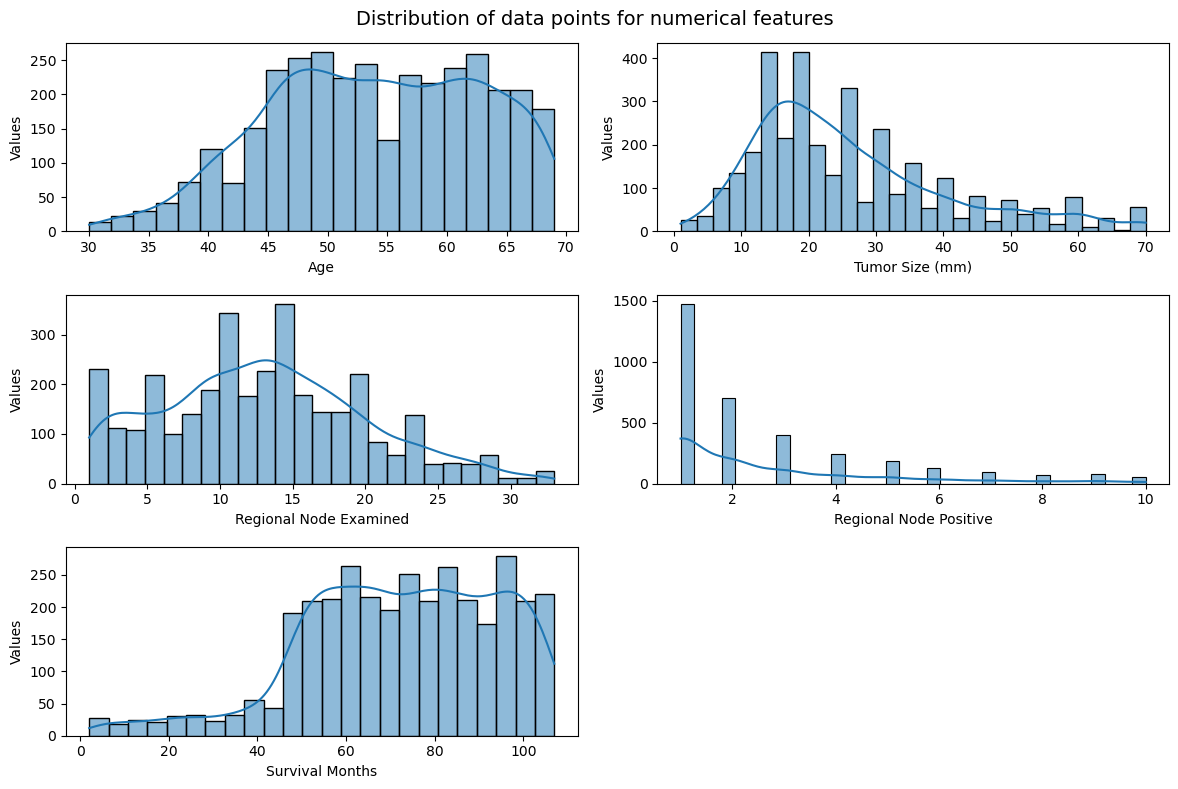

In [30]:
skew_cols=df.select_dtypes(exclude='object').skew(axis=0).index

fig,axes=plt.subplots(nrows=3, ncols=2,figsize=(12,8),dpi=100)
fig.suptitle('Distribution of data points for numerical features',fontsize=14)

for col,ax in zip(skew_cols,axes.ravel()):
    sns.histplot(data=df,x=col,kde='True',ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Values')
fig.tight_layout()
fig.delaxes(axes[2,1])

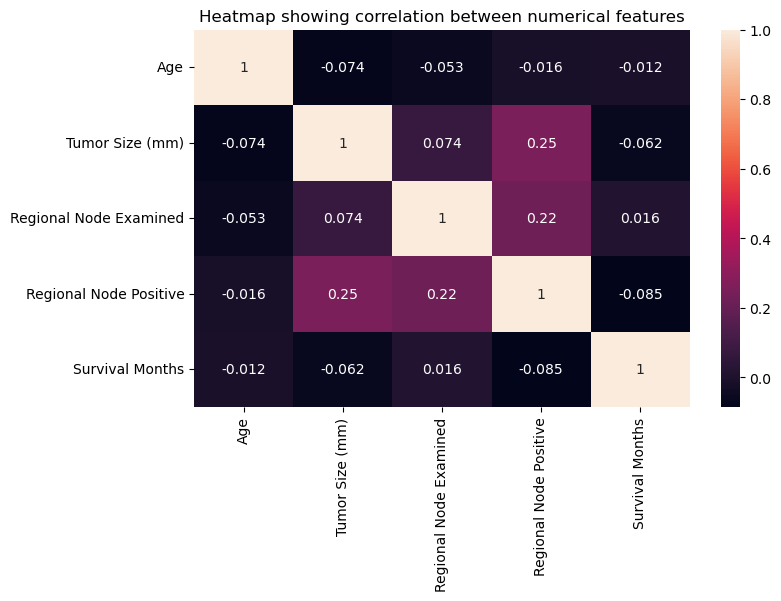

In [31]:
plt.figure(figsize=(8,5),dpi=100)
sns.heatmap(df.corr(),annot=True)
plt.title('Heatmap showing correlation between numerical features');

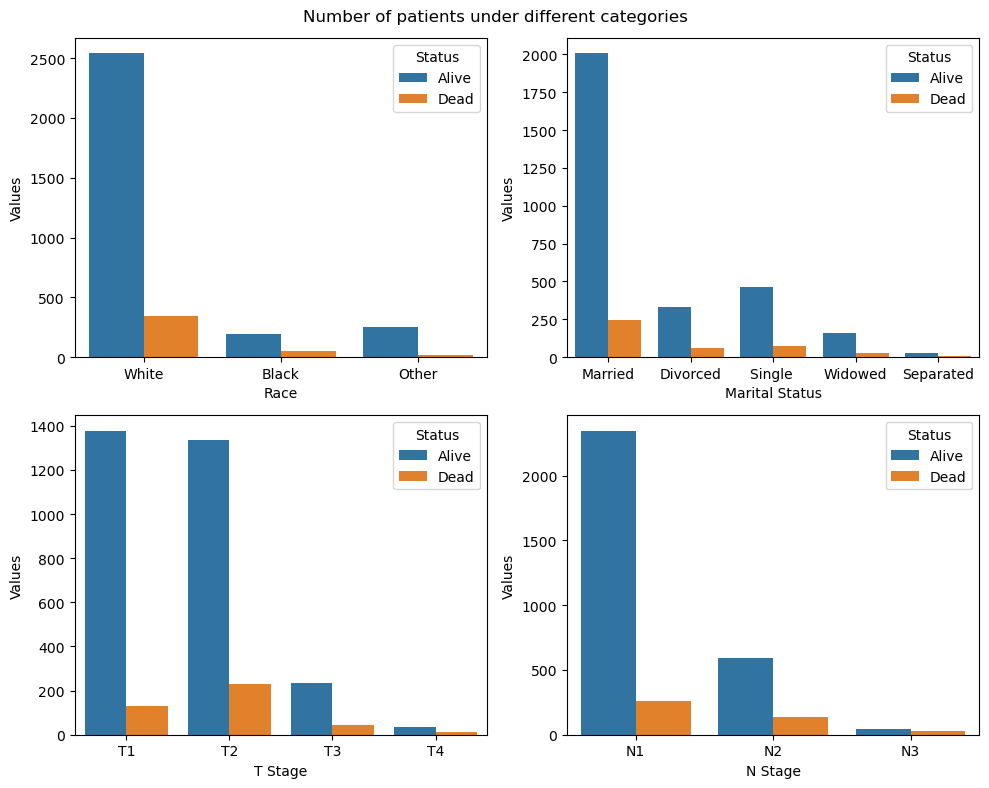

In [34]:
count_cols=['Race','Marital Status','T Stage','N Stage']
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,8),dpi=100)
fig.suptitle('Number of patients under different categories');
for col,ax in zip(count_cols,axes.ravel()):
    sns.countplot(data=df,x=col,hue='Status',ax=ax)
    ax.set_ylabel('Values')    
plt.tight_layout()

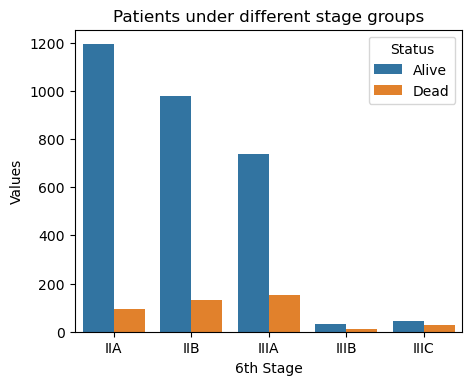

In [35]:
order_stage=['IIA','IIB','IIIA','IIIB','IIIC']
plt.figure(figsize=(5,4),dpi=100)
sns.countplot(data=df,x='6th Stage',hue='Status',order=order_stage)
plt.ylabel('Values')
plt.title('Patients under different stage groups');

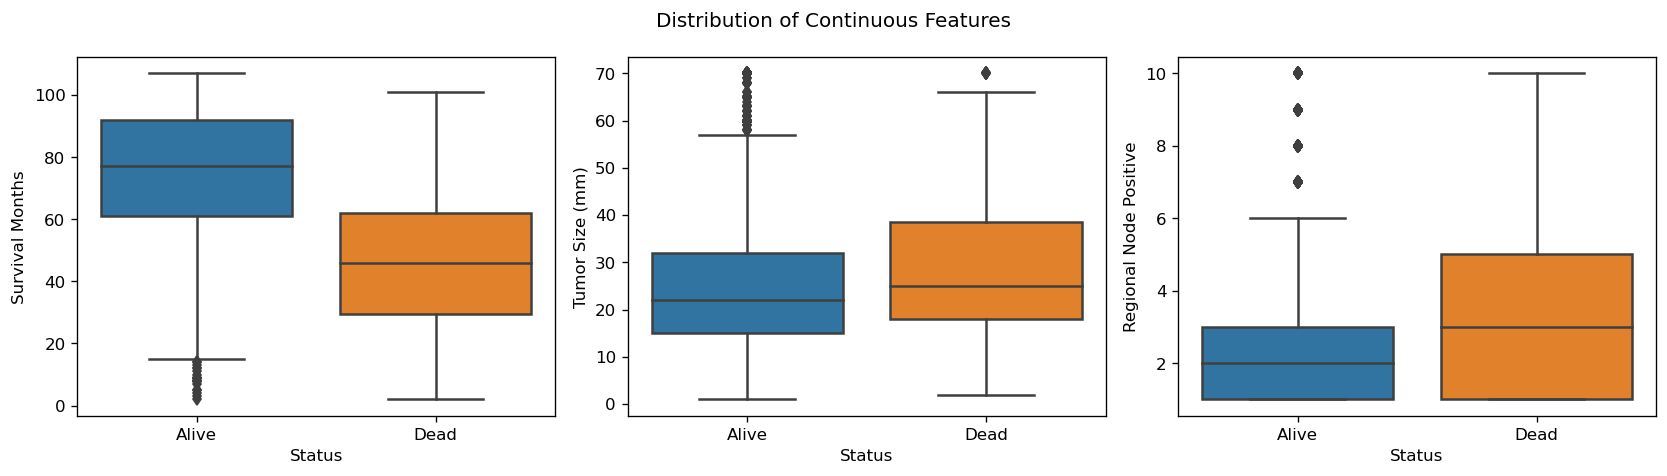

In [36]:
box_cols=['Survival Months','Tumor Size (mm)','Regional Node Positive']
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(14,4),dpi=120)
fig.suptitle('Distribution of Continuous Features');
for col,ax in zip(box_cols,axes.ravel()):
    sns.boxplot(data=df,x='Status',y=col,ax=ax)
plt.tight_layout()

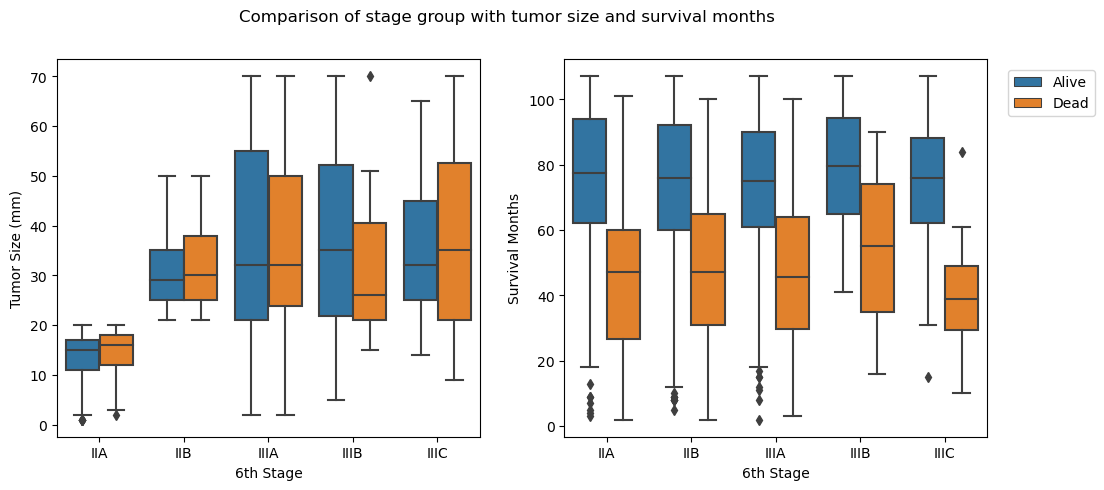

In [44]:
stage_cols=['Tumor Size (mm)','Survival Months']
order_stage=['IIA','IIB','IIIA','IIIB','IIIC']
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,5),dpi=100)
fig.suptitle('Comparison of stage group with tumor size and survival months');
for col,ax in zip(stage_cols,axes.ravel()):
    sns.boxplot(data=df,x='6th Stage',y=col,hue='Status',order=order_stage,ax=ax)
    ax.legend_.remove()
ax.legend(loc=(1.05,0.85));

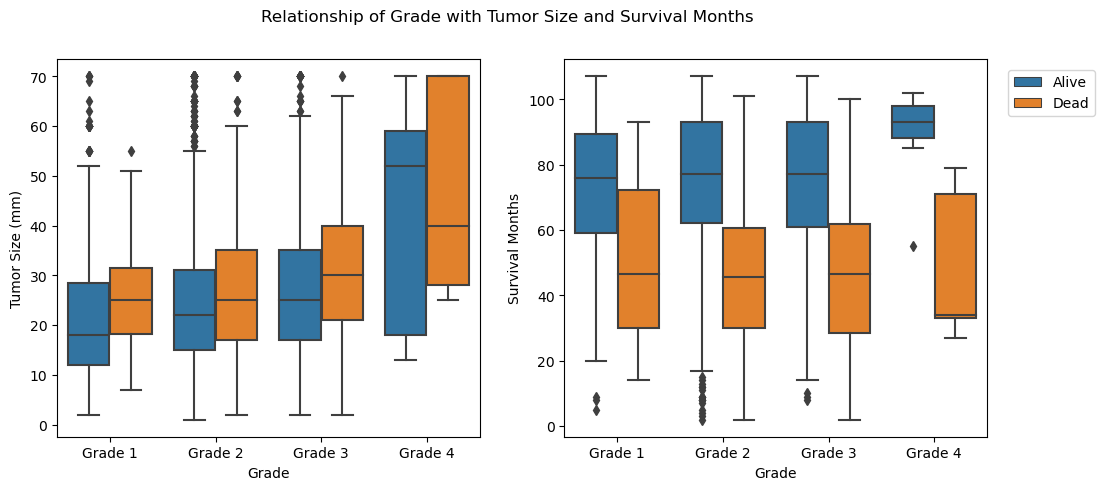

In [45]:
grade_cols=['Tumor Size (mm)','Survival Months']
grade_order=['Grade 1','Grade 2','Grade 3','Grade 4']
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,5),dpi=100)
fig.suptitle('Relationship of Grade with Tumor Size and Survival Months');
for col,ax in zip(grade_cols,axes.ravel()):
    sns.boxplot(data=df,x='Grade',y=col,hue='Status',order=grade_order,ax=ax)
    ax.legend_.remove()
ax.legend(loc=(1.05, 0.85));

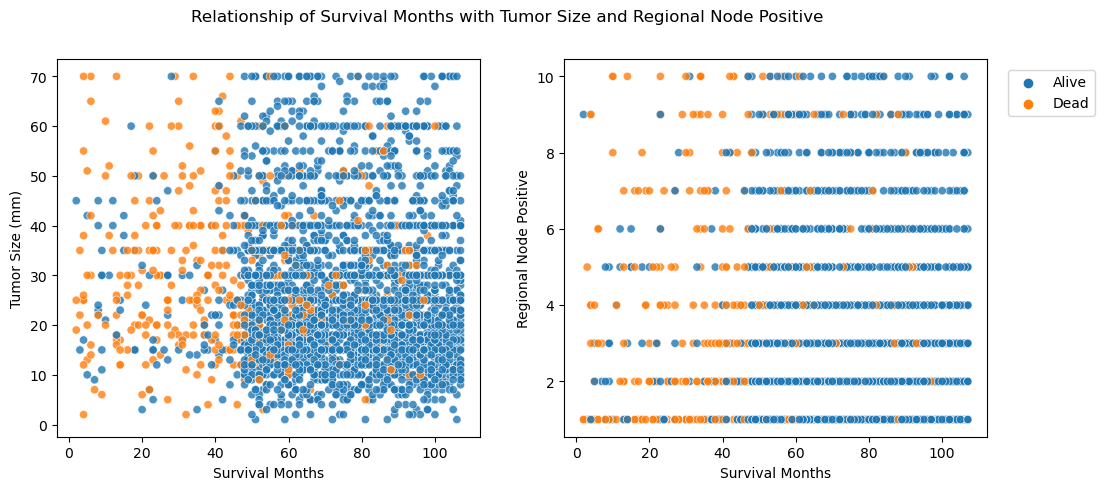

In [52]:
scatter_cols=['Tumor Size (mm)','Regional Node Positive']
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,5),dpi=100)
fig.suptitle('Relationship of Survival Months with Tumor Size and Regional Node Positive');
for col, ax in zip(scatter_cols,axes.ravel()):
    sns.scatterplot(data=df,x='Survival Months',y=col,hue='Status',ax=ax,alpha=0.8)
    ax.legend_.remove()
ax.legend(loc=(1.05, 0.85));

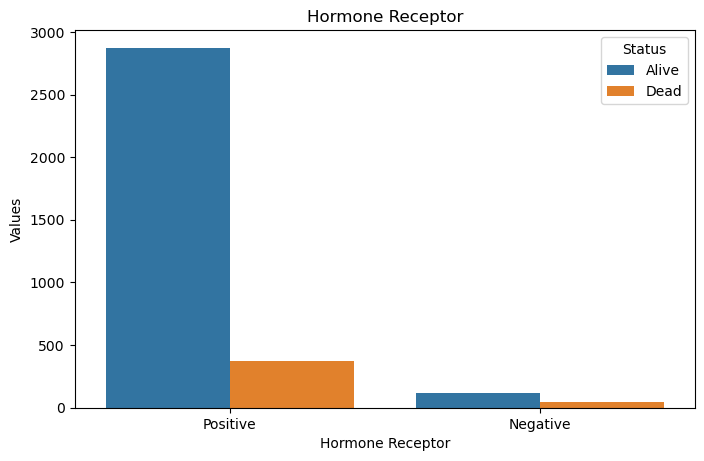

In [49]:
mask=(df['Estrogen Status']=='Positive') | (df['Progesterone Status']=='Positive')
conditions=[mask,~mask]
values=['Positive','Negative']
df['Hormone Receptor']=np.select(conditions,values)
plt.figure(figsize=(8,5),dpi=100)
sns.countplot(data=df,x='Hormone Receptor',hue='Status')
plt.ylabel('Values')
plt.title('Hormone Receptor');

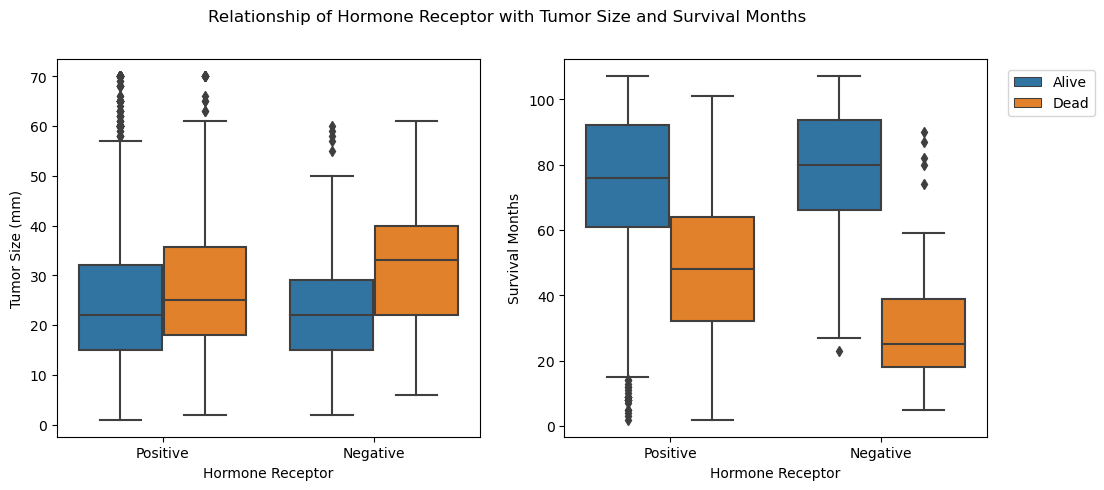

In [53]:
grade_cols=['Tumor Size (mm)','Survival Months']
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,5),dpi=100)
fig.suptitle('Relationship of Hormone Receptor with Tumor Size and Survival Months');
for col,ax in zip(grade_cols,axes.ravel()):
    sns.boxplot(data=df,x='Hormone Receptor',y=col,hue='Status',ax=ax)
    ax.legend_.remove()
ax.legend(loc=(1.05,0.85));

# Feature correlation with target label

In [54]:
df.sample(5,random_state=5)

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,Differentiate,Grade,A Stage,Tumor Size (mm),Estrogen Status,Progesterone Status,Regional Node Examined,Regional Node Positive,Survival Months,Status,Hormone Receptor
170,69,Other,Widowed,T2,N1,IIB,Moderately differentiated,Grade 2,Regional,40,Positive,Positive,20,2,62,Dead,Positive
3109,47,Black,Divorced,T1,N1,IIA,Poorly differentiated,Grade 3,Regional,19,Positive,Positive,12,1,94,Alive,Positive
1732,45,Other,Married,T1,N1,IIA,Moderately differentiated,Grade 2,Regional,17,Positive,Positive,6,1,107,Alive,Positive
3602,49,White,Married,T2,N1,IIB,Moderately differentiated,Grade 2,Regional,40,Positive,Positive,5,2,49,Alive,Positive
3105,54,White,Divorced,T2,N2,IIIA,Moderately differentiated,Grade 2,Regional,35,Positive,Positive,19,7,53,Alive,Positive


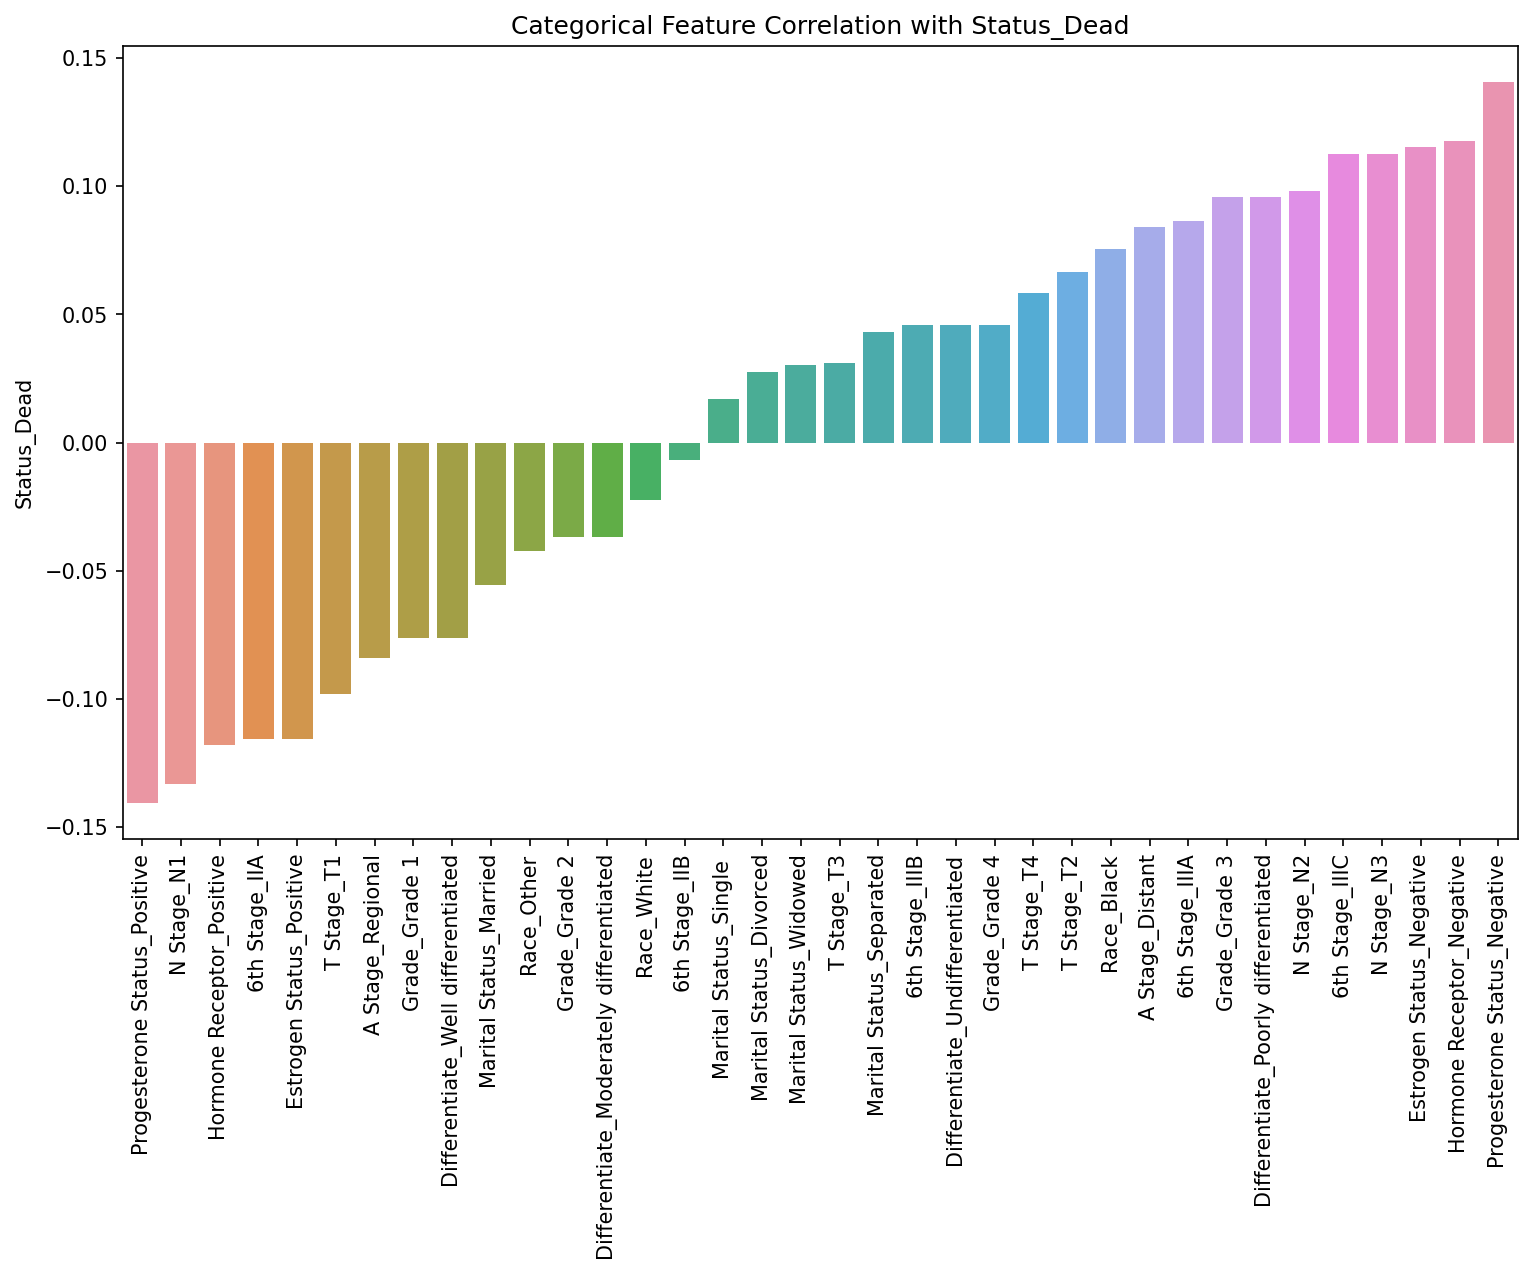

In [55]:
feature_obj_df=pd.get_dummies(df.select_dtypes('object'))
feature_obj_corr=feature_obj_df.corr().sort_values(by='Status_Dead')['Status_Dead'][1:-1]
feature_obj_corr=pd.DataFrame(feature_obj_corr).reset_index()

plt.figure(figsize=(12,7),dpi=150)
sns.barplot(data=feature_obj_corr,x='index',y='Status_Dead')
plt.xticks(rotation=90)
plt.xlabel('')
plt.title("Categorical Feature Correlation with Status_Dead");

# ML Models

In [5]:
seed = 101
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
cls_labels = ['Alive', 'Dead']
cls_models = {'Logistic Regression' : LogisticRegression(max_iter=100000, random_state=seed), 
              'SVC' : SVC(max_iter=100000, random_state=seed), 
              'Decision Tree' : DecisionTreeClassifier(random_state=seed),
              'Random Forest' : RandomForestClassifier(random_state=seed), 'AdaBoost' : AdaBoostClassifier(random_state=seed), 
              'GradientBoosting' : GradientBoostingClassifier(random_state=seed)}

def plot_confusion_matrix(models, y_test, y_pred_list, approach, rows, cols, w, h):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(w,h), dpi=100)
    fig.suptitle(f'Confusion Matrix for different models - {approach}', fontsize=14, y=0.97)
    for name, y_pred, ax in zip(models, y_pred_list, axes.ravel()):
        conf_mat = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, ax=ax, fmt='d', cmap='mako_r')
        ax.set_title(name)
        ax.set_xticklabels(cls_labels)
        ax.set_yticklabels(cls_labels)
    plt.tight_layout()
    plt.show()
        
def run_baseline_models():
    
    accuracy_list = []
    recall_list = []
    precision_list = []
    
    for name, model in cls_models.items():
        
        score_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        score_precision = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision')
        score_recall = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall')        
        
        mean_accuracy_train = np.mean(score_accuracy.mean())
        mean_precision_train = np.mean(score_precision.mean())
        mean_recall_train = np.mean(score_recall.mean())
        
        accuracy_train.append(mean_accuracy_train)
        precision_train.append(mean_precision_train)
        recall_train.append(mean_recall_train)
        
        model.fit(X_train, y_train)
        
        
        y_predict = model.predict(X_test)
        y_pred_baseline.append(y_predict)

        
        accuracy_pred = accuracy_score(y_test, y_predict)
        precision_pred = precision_score(y_test, y_predict)
        recall_pred = recall_score(y_test, y_predict)
        
        accuracy_test.append(accuracy_pred)
        precision_test.append(precision_pred)
        recall_test.append(recall_pred)

# Baseline Models

In [6]:
df['Status']=df['Status'].map({'Alive':0,'Dead':1}).astype('int64')
new_df = df.copy()
num_cols=new_df.select_dtypes('int').columns
num_cols=num_cols[0:-1] 
scaler=StandardScaler()
scaled_numcols_df = pd.DataFrame(scaler.fit_transform(new_df[num_cols]),columns=num_cols,index= new_df.index)
for col in num_cols:
    new_df[col]=scaled_numcols_df[col]
    
X=pd.get_dummies(new_df.drop('Status',axis=1),drop_first=True)
y=df['Status']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=seed)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (2384, 29)
Shape of X_test: (1023, 29)


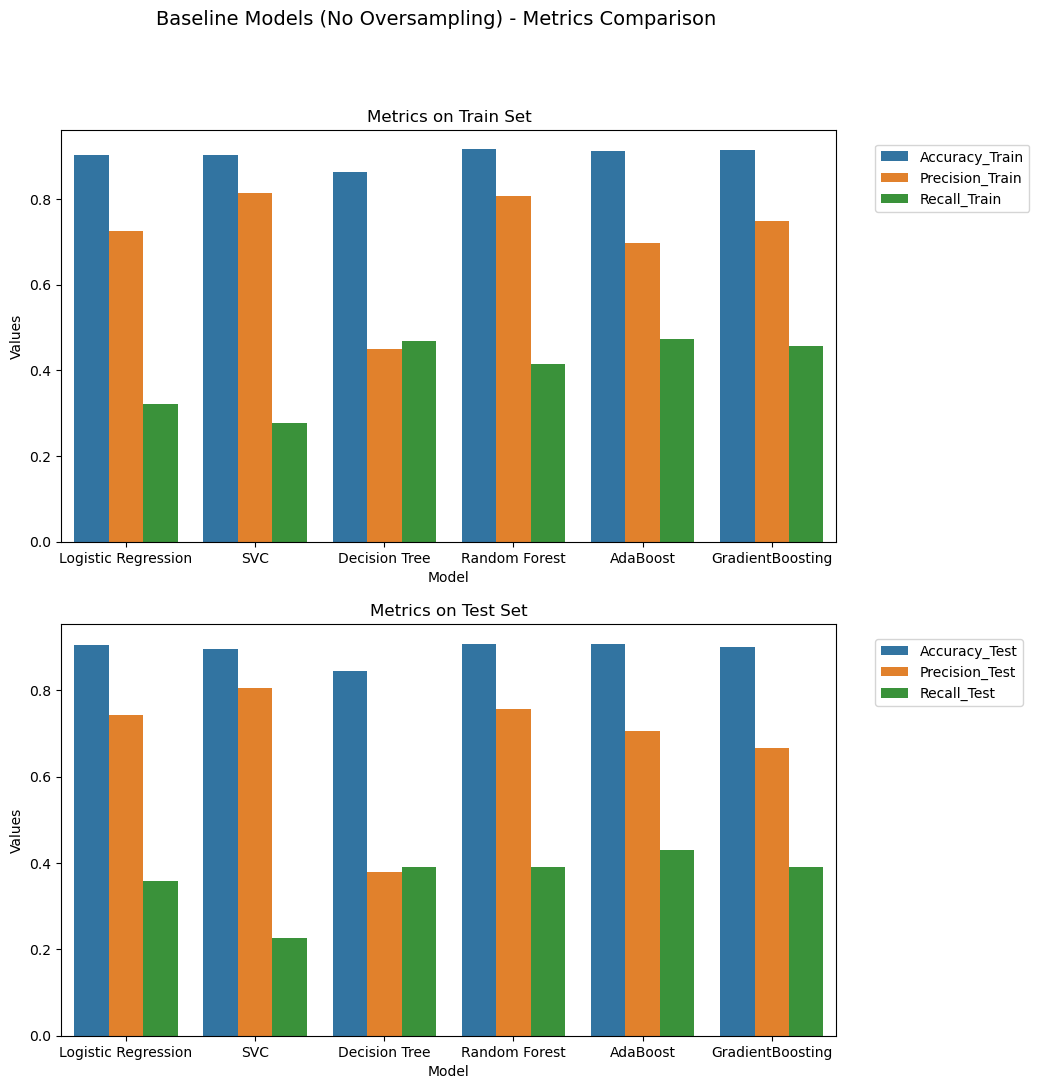

In [58]:
accuracy_train=[]
precision_train=[]
recall_train=[]
accuracy_test=[]
precision_test=[]
recall_test=[]
y_pred_baseline=[]

run_baseline_models()
metrics_base_train=pd.DataFrame(list(zip(cls_models.keys(),accuracy_train,precision_train,recall_train)), 
                                  columns=['Model','Accuracy_Train','Precision_Train','Recall_Train'])

metrics_base_test=pd.DataFrame(list(zip(cls_models.keys(),accuracy_test,precision_test,recall_test)), 
                                  columns=['Model','Accuracy_Test','Precision_Test','Recall_Test'])

metrics_melt_base_train=pd.melt(metrics_base_train,id_vars=['Model'], 
                                  value_vars=['Accuracy_Train','Precision_Train','Recall_Train'])

metrics_melt_base_test=pd.melt(metrics_base_test,id_vars=['Model'], 
                                 value_vars=['Accuracy_Test','Precision_Test','Recall_Test'])

fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(10,12),dpi=100)
fig.suptitle('Baseline Models (No Oversampling) - Metrics Comparison',fontsize=14)
sns.barplot(data=metrics_melt_base_train,x='Model',y='value',hue='variable',ax=ax1)
sns.barplot(data=metrics_melt_base_test,x='Model',y='value',hue='variable',ax=ax2)

ax1.set_ylabel('Values')
ax1.set_title('Metrics on Train Set')
ax1.legend(loc=(1.05, 0.80))
ax2.set_ylabel('Values')
ax2.set_title('Metrics on Test Set')
ax2.legend(loc=(1.05, 0.80));

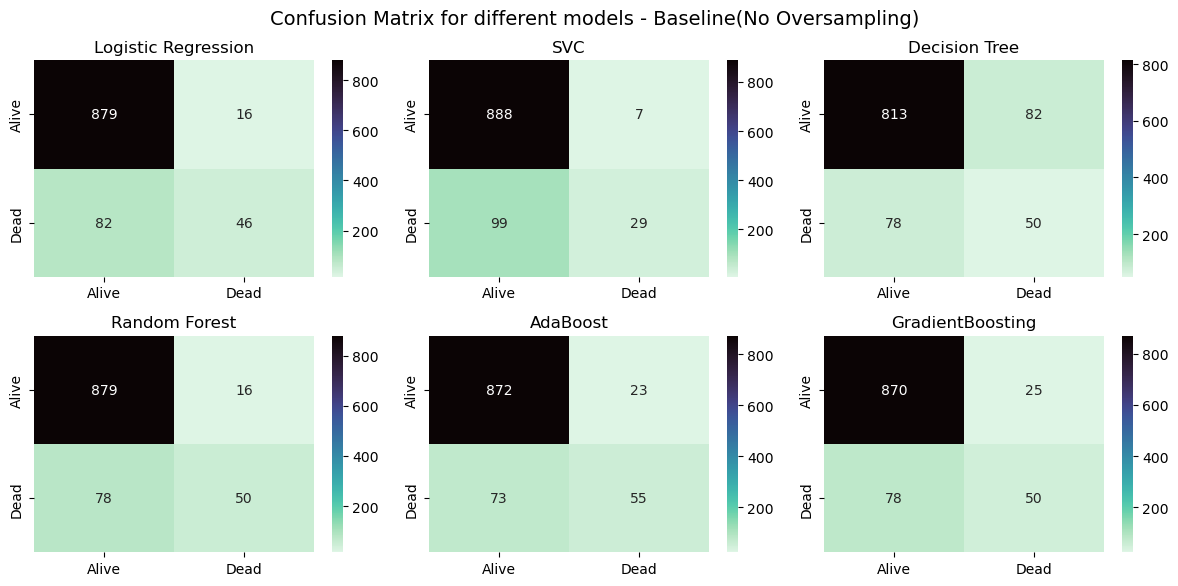

In [60]:
plot_confusion_matrix(cls_models,y_test,y_pred_baseline,'Baseline(No Oversampling)',2,3,12,6)

In [76]:
metrics_base_train

,Model,Accuracy_Train,Precision_Train,Recall_Train
0,Logistic Regression,0.901847,0.726299,0.322304
1,SVC,0.903111,0.813513,0.275756
2,Decision Tree,0.864095,0.448929,0.467313
3,Random Forest,0.916115,0.806007,0.415490
4,AdaBoost,0.911079,0.696736,0.473814
5,GradientBoosting,0.915273,0.749679,0.456153


In [77]:
metrics_base_test

,Model,Accuracy_Test,Precision_Test,Recall_Test
0,Logistic Regression,0.904203,0.741935,0.359375
1,SVC,0.896383,0.805556,0.226562
2,Decision Tree,0.843597,0.378788,0.390625
3,Random Forest,0.908113,0.757576,0.390625
4,AdaBoost,0.906158,0.705128,0.429688
5,GradientBoosting,0.899316,0.666667,0.390625


# Models with Random Oversampling

In [78]:
def run_sampling_model(estimator, method):    
    cv=kfold 
    accuracy_list=[]
    recall_list=[]
    precision_list=[]
    sampling_params={'sampling_strategy':'auto','random_state':seed}
    
    if method=='RandomOverSample':
        rand_over=RandomOverSampler(**sampling_params)
    elif method=='SMOTE':
        rand_over=SMOTE(**sampling_params)
        
    for train,val in cv.split(X_train,y_train):

        pipeline=make_pipeline(rand_over,estimator)  
        model=pipeline.fit(X_train.iloc[train],y_train.iloc[train])
        y_val_predict=model.predict(X_train.iloc[val])
        accuracy_list.append(accuracy_score(y_train.iloc[val],y_val_predict))    
        precision_list.append(precision_score(y_train.iloc[val],y_val_predict))
        recall_list.append(recall_score(y_train.iloc[val],y_val_predict))

    mean_accuracy_train=np.mean(accuracy_list)
    mean_precision_train=np.mean(precision_list)
    mean_recall_train=np.mean(recall_list)
    
    accuracy_train.append(mean_accuracy_train)
    precision_train.append(mean_precision_train)
    recall_train.append(mean_recall_train)
    
    y_predict=model.predict(X_test)
    
    accuracy_pred=accuracy_score(y_test,y_predict)
    precision_pred=precision_score(y_test,y_predict)
    recall_pred=recall_score(y_test,y_predict)
    
    accuracy_test.append(accuracy_pred)
    precision_test.append(precision_pred)
    recall_test.append(recall_pred)
    
    if method=='RandomOverSample':
        y_pred_list_rand.append(y_predict)
    elif method=='SMOTE':
        y_pred_list_smote.append(y_predict)

In [79]:
accuracy_train=[]
precision_train=[]
recall_train=[]
accuracy_test=[]
precision_test=[]
recall_test=[]
y_pred_list_rand=[]
method='RandomOverSample'

for name,model in cls_models.items():
    run_sampling_model(model,method)

metrics_rand_train=pd.DataFrame(list(zip(cls_models.keys(),accuracy_train,precision_train,recall_train)), 
                                  columns=['Model','Accuracy_Train','Precision_Train','Recall_Train'])

metrics_rand_test=pd.DataFrame(list(zip(cls_models.keys(),accuracy_test,precision_test,recall_test)), 
                                  columns=['Model','Accuracy_Test','Precision_Test','Recall_Test'])

metrics_melt_rand_train=pd.melt(metrics_rand_train,id_vars=['Model'], 
                                  value_vars=['Accuracy_Train','Precision_Train','Recall_Train'])

metrics_melt_rand_test=pd.melt(metrics_rand_test,id_vars=['Model'], 
                                 value_vars=['Accuracy_Test','Precision_Test','Recall_Test'])

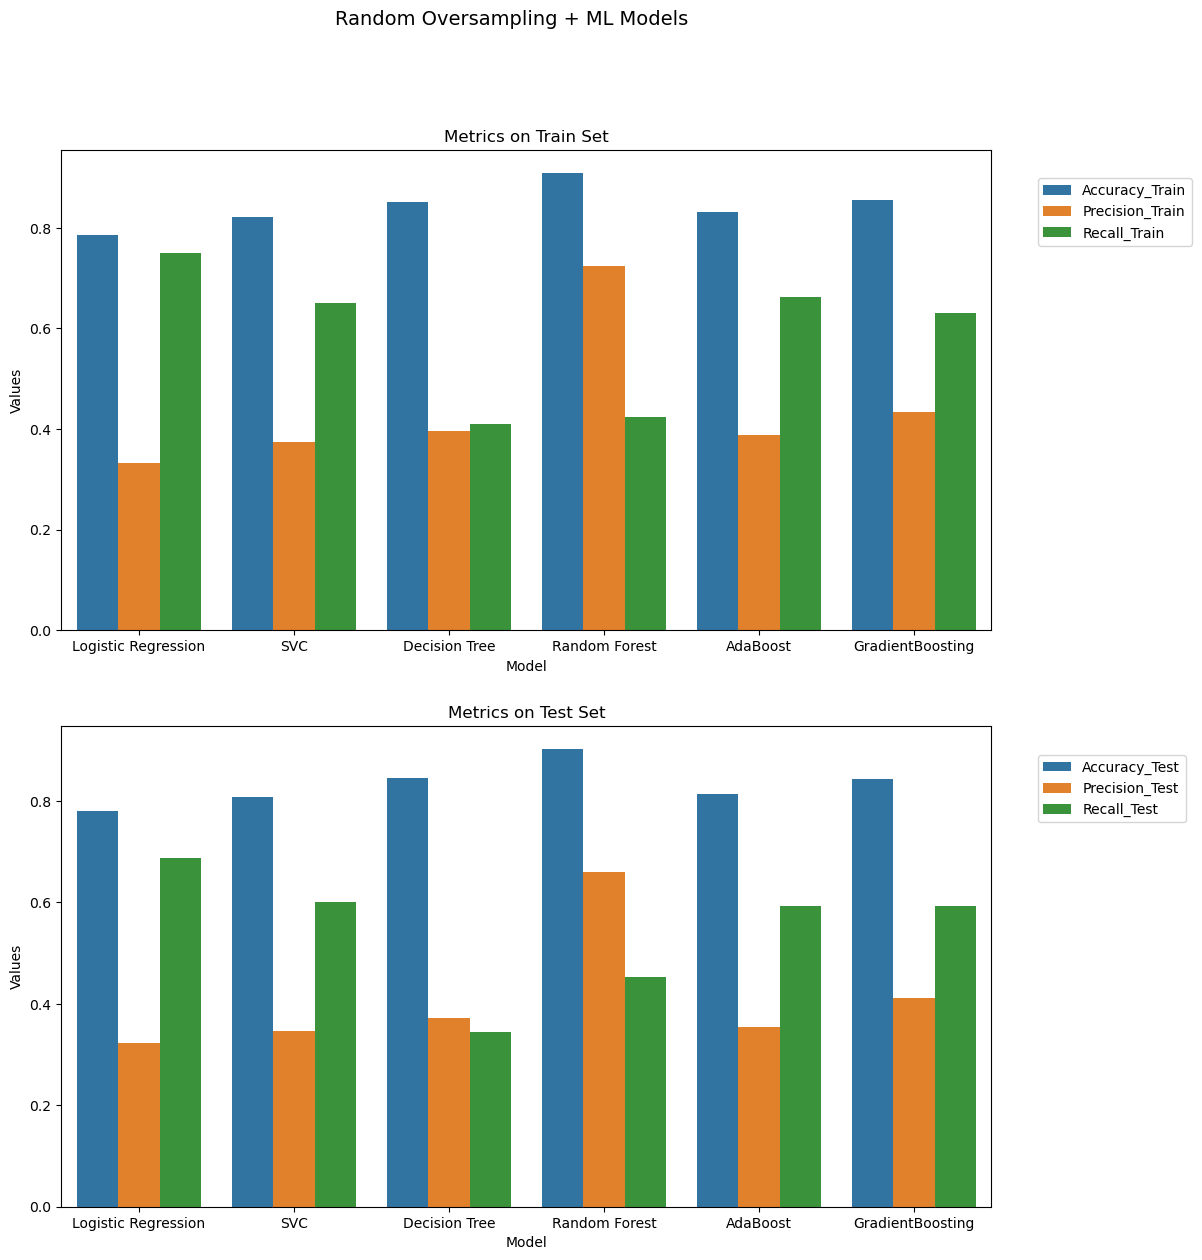

In [80]:
fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(12,14),dpi=100)
fig.suptitle('Random Oversampling + ML Models',fontsize=14)
sns.barplot(data=metrics_melt_rand_train,x='Model',y='value',hue='variable',ax=ax1)
sns.barplot(data=metrics_melt_rand_test,x='Model',y='value',hue='variable',ax=ax2)

ax1.set_ylabel('Values')
ax1.set_title('Metrics on Train Set')
ax1.legend(loc=(1.05,0.80))

ax2.set_ylabel('Values')
ax2.set_title('Metrics on Test Set')
ax2.legend(loc=(1.05,0.80))

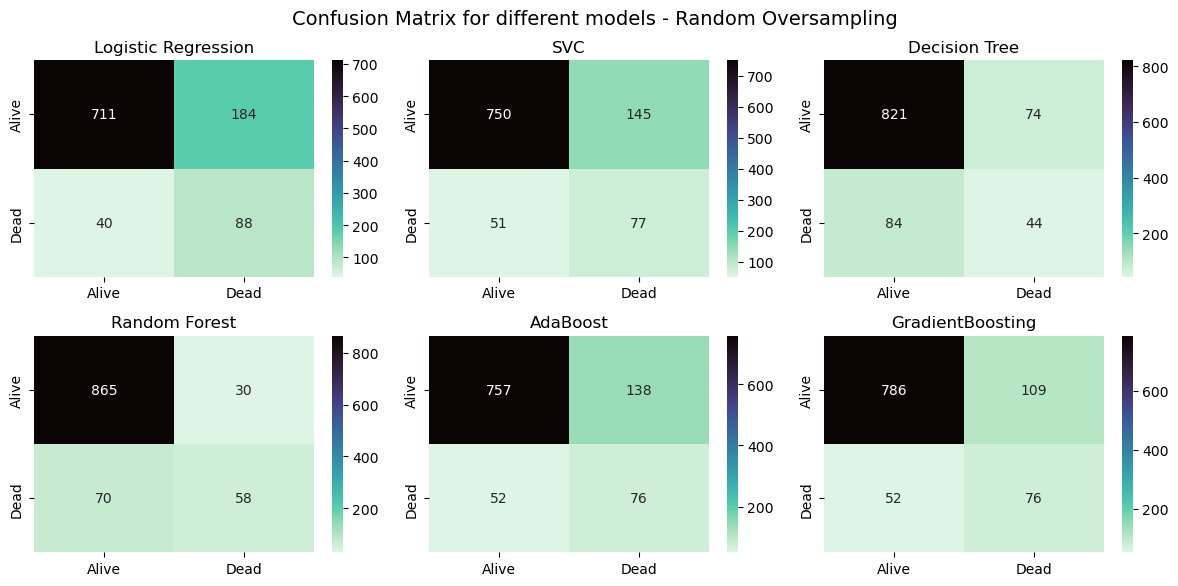

In [81]:
plot_confusion_matrix(cls_models,y_test,y_pred_list_rand,'Random Oversampling',2,3,12,6)

In [82]:
metrics_rand_train

,Model,Accuracy_Train,Precision_Train,Recall_Train
0,Logistic Regression,0.786489,0.332720,0.749538
1,SVC,0.822135,0.373544,0.650452
2,Decision Tree,0.852351,0.396311,0.409686
3,Random Forest,0.909822,0.723636,0.424051
4,AdaBoost,0.831794,0.388069,0.661858
5,GradientBoosting,0.854859,0.433526,0.630907


In [83]:
metrics_rand_test

,Model,Accuracy_Test,Precision_Test,Recall_Test
0,Logistic Regression,0.781036,0.323529,0.687500
1,SVC,0.808407,0.346847,0.601562
2,Decision Tree,0.845552,0.372881,0.343750
3,Random Forest,0.902248,0.659091,0.453125
4,AdaBoost,0.814272,0.355140,0.593750
5,GradientBoosting,0.842620,0.410811,0.593750


# Models with SMOTE

In [86]:
accuracy_train=[]
precision_train=[]
recall_train=[]
accuracy_test=[]
precision_test=[]
recall_test=[]
y_pred_list_smote=[]
method='SMOTE'

for name,model in cls_models.items():
    run_sampling_model(model,method)

metrics_smote_train=pd.DataFrame(list(zip(cls_models.keys(),accuracy_train, 
                                           precision_train,recall_train)), 
                                  columns=['Model','Accuracy_Train','Precision_Train','Recall_Train'])

metrics_smote_test=pd.DataFrame(list(zip(cls_models.keys(),accuracy_test, 
                                           precision_test,recall_test)), 
                                  columns=['Model','Accuracy_Test','Precision_Test','Recall_Test'])

metrics_melt_smote_train=pd.melt(metrics_smote_train,id_vars=['Model'], 
                                  value_vars=['Accuracy_Train','Precision_Train','Recall_Train'])

metrics_melt_smote_test=pd.melt(metrics_smote_test,id_vars=['Model'], 
                                 value_vars=['Accuracy_Test','Precision_Test','Recall_Test'])

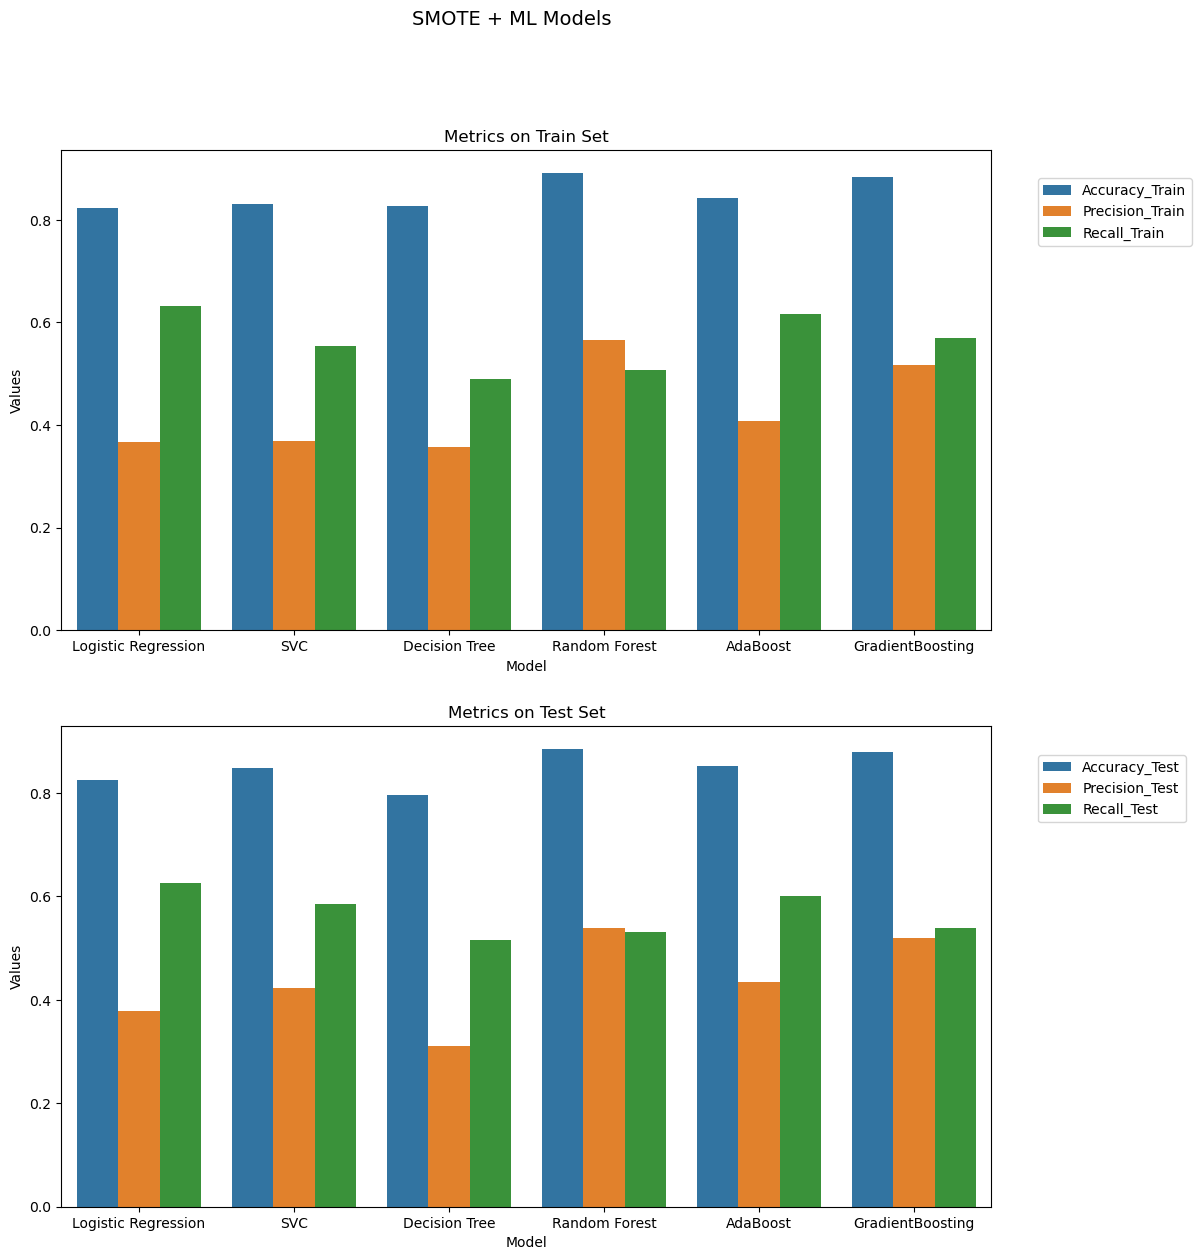

In [89]:
fig,(ax1, ax2)=plt.subplots(nrows=2,ncols=1,figsize=(12, 14),dpi=100)
fig.suptitle('SMOTE + ML Models',fontsize=14)
sns.barplot(data=metrics_melt_smote_train,x='Model',y='value',hue='variable',ax=ax1)
sns.barplot(data=metrics_melt_smote_test,x='Model',y='value',hue='variable',ax=ax2)

ax1.set_ylabel('Values')
ax1.set_title('Metrics on Train Set')
ax1.legend(loc=(1.05,0.80))

ax2.set_ylabel('Values')
ax2.set_title('Metrics on Test Set')
ax2.legend(loc=(1.05,0.80))

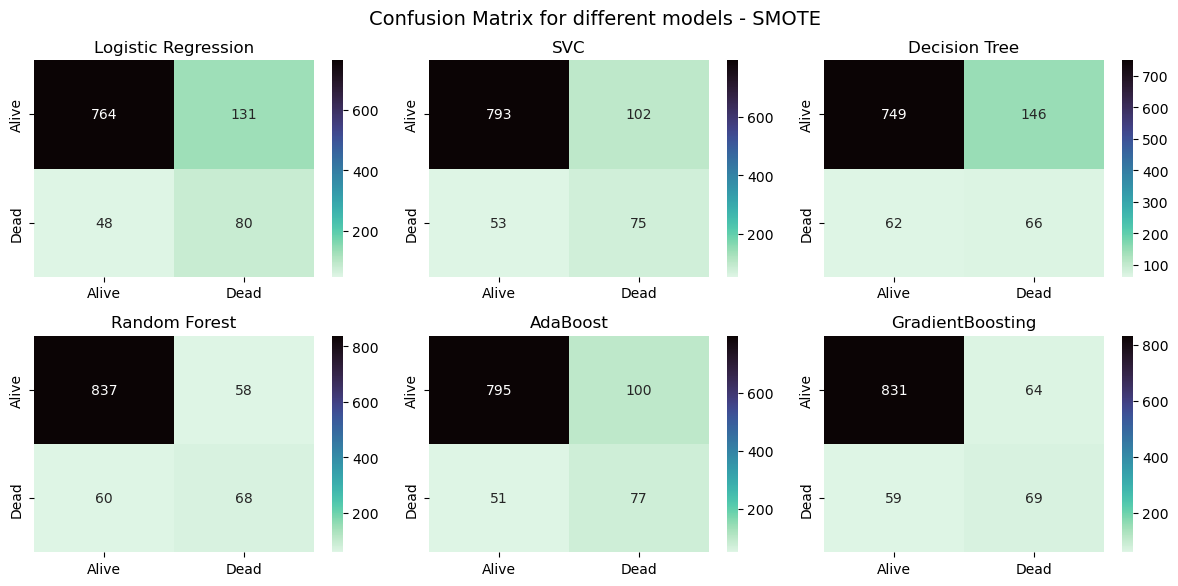

In [90]:
plot_confusion_matrix(cls_models,y_test,y_pred_list_smote,'SMOTE',2,3,12,6)

In [87]:
metrics_smote_train

,Model,Accuracy_Train,Precision_Train,Recall_Train
0,Logistic Regression,0.822568,0.366931,0.631939
1,SVC,0.830112,0.369560,0.554557
2,Decision Tree,0.827595,0.358025,0.489103
3,Random Forest,0.892201,0.565234,0.507924
4,AdaBoost,0.843542,0.407536,0.615807
5,GradientBoosting,0.883390,0.517261,0.570618


In [88]:
metrics_smote_test

,Model,Accuracy_Test,Precision_Test,Recall_Test
0,Logistic Regression,0.825024,0.379147,0.625000
1,SVC,0.848485,0.423729,0.585938
2,Decision Tree,0.796676,0.311321,0.515625
3,Random Forest,0.884653,0.539683,0.531250
4,AdaBoost,0.852395,0.435028,0.601562
5,GradientBoosting,0.879765,0.518797,0.539062


# Models with SMOTE + GridSearchCV

In [7]:
def run_sampling_grid(estimator): 
    cv=kfold
    accuracy_list=[]
    recall_list=[]
    precision_list=[]
    sampling_params={'sampling_strategy' : 'auto', 'random_state' : seed}
    rand_over=SMOTE(**sampling_params)
        
    for train,val in cv.split(X_train, y_train):
        pipeline=make_pipeline(rand_over, estimator)
        model=pipeline.fit(X_train.iloc[train], y_train.iloc[train])
        model_best=estimator.best_estimator_
        y_val_predict=model_best.predict(X_train.iloc[val])

        recall_list.append(pipeline.score(X_train.iloc[val], y_train.iloc[val]))
        accuracy_list.append(accuracy_score(y_train.iloc[val], y_val_predict))
        precision_list.append(precision_score(y_train.iloc[val], y_val_predict))
        
    
    mean_accuracy_train=np.mean(accuracy_list)
    mean_precision_train=np.mean(precision_list)
    mean_recall_train=np.mean(recall_list)
    
    accuracy_gtrain.append(mean_accuracy_train)
    precision_gtrain.append(mean_precision_train)
    recall_gtrain.append(mean_recall_train)
    
    y_predict=model_best.predict(X_test)
    y_pred_list_grid.append(y_predict)
    best_params.append(estimator.best_params_)
    

    accuracy_pred=accuracy_score(y_test, y_predict)
    precision_pred=precision_score(y_test, y_predict)
    recall_pred=recall_score(y_test, y_predict)
    
    accuracy_gtest.append(accuracy_pred)
    precision_gtest.append(precision_pred)
    recall_gtest.append(recall_pred)

In [8]:
accuracy_gtrain=[]
precision_gtrain=[]
recall_gtrain=[]
accuracy_gtest=[]
precision_gtest=[]
recall_gtest=[]
y_pred_list_grid=[]
score='recall'
grid_models=['Random Forest Classifier','AdaBoost Classifier','Gradient Boosting Classifier']

param_rfc={'n_estimators':np.arange(50,300,25),'criterion':['gini', 'entropy'], 
             'max_features':['sqrt','log2'],'min_samples_leaf':[1, 2, 4, 5], 
             'bootstrap':[True,False]}

grid_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=seed), 
                        param_grid=param_rfc,scoring=score,n_jobs=-1)

param_ada={'base_estimator':[DecisionTreeClassifier(),RandomForestClassifier()], 
             'n_estimators':np.arange(50,350,25), 
             'learning_rate':np.arange(0.2,2.2,0.2)}

grid_ada=GridSearchCV(estimator=AdaBoostClassifier(random_state=seed), 
                        param_grid=param_ada,scoring=score,n_jobs=-1)

param_grb={'n_estimators':np.arange(50,200,25),'learning_rate':np.arange(0.2,2.0,0.2),
             'max_depth':np.arange(3,7)}

grid_grb=GridSearchCV(estimator=GradientBoostingClassifier(random_state=seed), 
                        param_grid=param_grb,scoring=score,n_jobs=-1)

grid_cv=[grid_rfc,grid_ada,grid_grb]
best_params=[]

for model in grid_cv:
    run_sampling_grid(model)

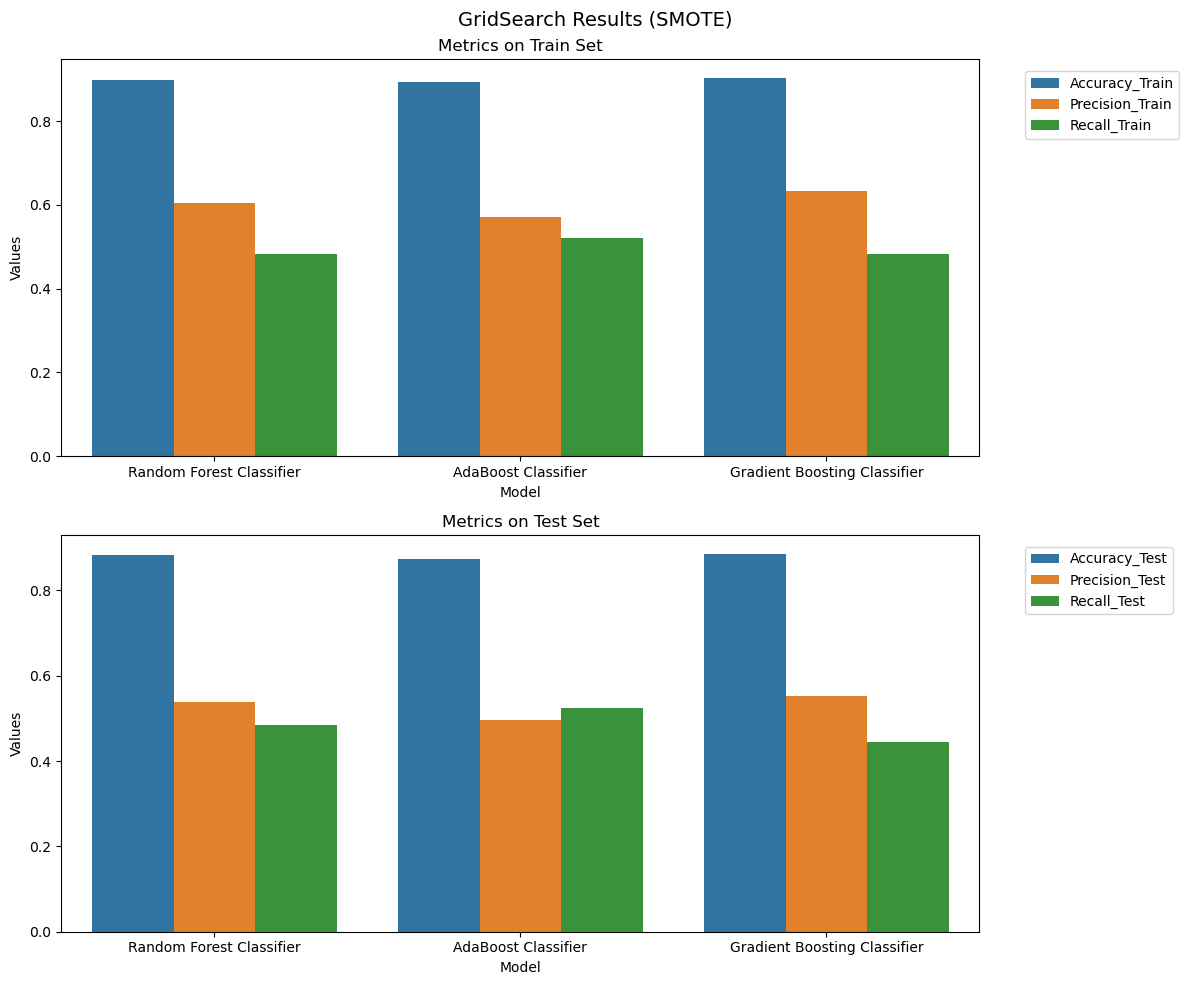

In [9]:
metrics_grid_train=pd.DataFrame(list(zip(grid_models,accuracy_gtrain,precision_gtrain,recall_gtrain)), 
                                  columns=['Model','Accuracy_Train','Precision_Train','Recall_Train'])

metrics_grid_test=pd.DataFrame(list(zip(grid_models,accuracy_gtest,precision_gtest,recall_gtest)), 
                                  columns=['Model','Accuracy_Test','Precision_Test','Recall_Test'])

metrics_melt_grid_train=pd.melt(metrics_grid_train,id_vars=['Model'], 
                                  value_vars=['Accuracy_Train','Precision_Train','Recall_Train'])

metrics_melt_grid_test = pd.melt(metrics_grid_test, id_vars=['Model'], 
                                 value_vars=['Accuracy_Test','Precision_Test','Recall_Test'])

fig,(ax1, ax2)=plt.subplots(nrows=2,ncols=1,figsize=(12, 10),dpi=100)
fig.suptitle('GridSearch Results (SMOTE)',fontsize=14)
sns.barplot(data=metrics_melt_grid_train,x='Model',y='value',hue='variable',ax=ax1)
sns.barplot(data=metrics_melt_grid_test,x='Model',y='value',hue='variable',ax=ax2)


ax1.set_ylabel('Values')
ax1.set_title('Metrics on Train Set')
ax1.legend(loc=(1.05,0.80))

ax2.set_ylabel('Values')
ax2.set_title('Metrics on Test Set')
ax2.legend(loc=(1.05,0.80))

plt.tight_layout();

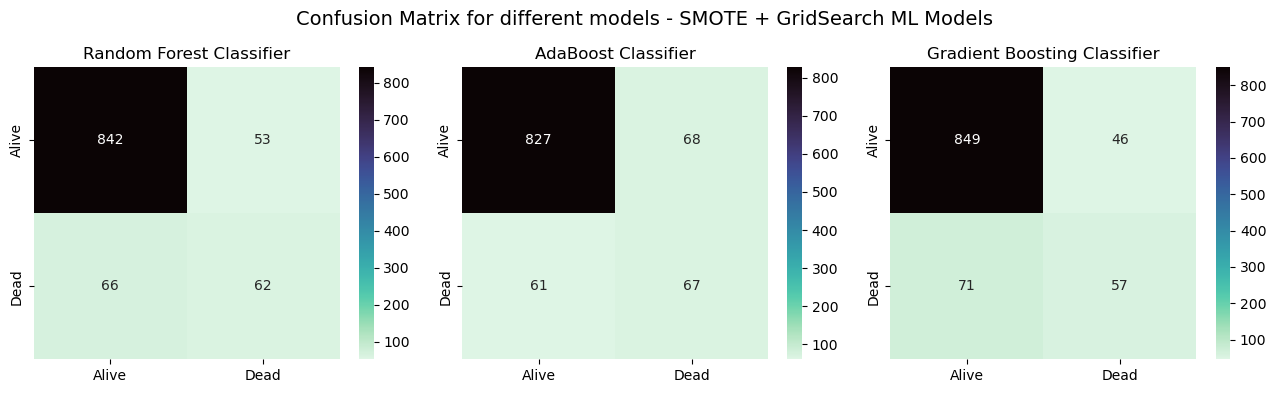

In [10]:
plot_confusion_matrix(grid_models,y_test,y_pred_list_grid,'SMOTE + GridSearch ML Models',1,3,13,4)

In [11]:
metrics_grid_train

,Model,Accuracy_Train,Precision_Train,Recall_Train
0,Random Forest Classifier,0.898489,0.605068,0.483019
1,AdaBoost Classifier,0.893035,0.571135,0.520253
2,Gradient Boosting Classifier,0.902267,0.632362,0.483558


In [12]:
metrics_grid_test

,Model,Accuracy_Test,Precision_Test,Recall_Test
0,Random Forest Classifier,0.883675,0.539130,0.484375
1,AdaBoost Classifier,0.873900,0.496296,0.523438
2,Gradient Boosting Classifier,0.885630,0.553398,0.445312
